# FCI ID model systems

In [1]:
#%matplotlib widget
import numpy as np
from numpy.random import Generator, PCG64
#from scipy.spatial.distance import pdist, cdist
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from pyFCI import pyFCI

from sklearn.neighbors import KernelDensity

from task_expanded import compute_id, local_fci_distance_ultrafast, flatten_variable
from compute_local_fci_smart_all import weighted_percentile

In [2]:
import h5py

In [3]:
from matplotlib import font_manager
font_file = "/usr/share/fonts/avenir_ff/AvenirLTStd-Roman.ttf"
font_file_b = "/usr/share/fonts/avenir_ff/AvenirLTStd-Black.ttf"
font_file_c = "/usr/share/fonts/avenir_ff/AvenirLTStd-Book.ttf"
font_manager.fontManager.addfont(font_file)
font_manager.fontManager.addfont(font_file_b)
font_manager.fontManager.addfont(font_file_c)
my_style = {
    #'font.family': 'DejaVu Serif',
    'font.family': 'Avenir LT Std',
    #'font.sans-serif':  "Avenir",
    'font.size': 10,
    'axes.labelsize': 22,
    'axes.linewidth': 1.5,
    'axes.titlesize': 30,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'image.cmap': 'jet',
}
plt.style.use(my_style)

In [4]:
def KDTree_neighbors_dist(data,n_neighbors=2):
    """
    Computes the distances to the n_neighbors nearest neighbors
    """
    tree = KDTree(data)
    dists = tree.query(data, k=n_neighbors)
    nn_dist = dists[0][:, 1:]
    idxs =  dists[1][:, 1:]
    return nn_dist, idxs

In [5]:
def compute_n_centers_neighborhood(neighborhoods,l_dataset, n_neighborhoods, coefficient=50):
    inverse_fraction = 1/(neighborhoods / l_dataset)
    n_centers_max = int(inverse_fraction.max())
    n_centers_min = int(inverse_fraction.min()*coefficient)
    n_centers_for_neighborhoods = np.floor(np.logspace(np.log2(n_centers_min), np.log2(n_centers_max), n_neighborhoods, base=2)).astype(int)
    n_centers_for_neighborhoods = np.flip(n_centers_for_neighborhoods)
    return n_centers_for_neighborhoods, n_centers_min, n_centers_max


In [6]:
def flatten_variable(variable_2d,n_centers_for_neighborhoods, n_total_centers):
    variable_flat = np.zeros(n_total_centers)
    ncn_0 = n_centers_for_neighborhoods[0]
    variable_flat[:ncn_0] = variable_2d[:ncn_0,0]
    for i, ncn in enumerate(n_centers_for_neighborhoods[1:]):
        variable_flat[ncn_0:ncn_0+ncn] = variable_2d[:ncn,i+1]
        ncn_0 += ncn
    return variable_flat

In [7]:
 def unwrap_local_ids(local_ids):
    local_ids_2d = local_ids[:,:,1]
    GoF = local_ids[:,:,2]
    k = local_ids[:,:,0]
    return local_ids_2d, GoF, k

In [8]:
def compute_weights(n_centers_for_neighborhoods):
    weights = np.repeat(1/n_centers_for_neighborhoods,n_centers_for_neighborhoods[0]).reshape((len(n_centers_for_neighborhoods),n_centers_for_neighborhoods[0])).T
    return weights

In [9]:
rng = Generator(PCG64())

In [10]:
compute = False
save = False

In [11]:
base_folder = "ID_results_smartNeigh/Model_datasets/"

## Swiss Roll

The swiss roll equation is:

$$
x = \phi\cos(\phi)$$
$$
y = \phi \sin(\phi)$$
$$
z = \psi$$
with $\phi$ random variable uniformly distributed in $1.5\pi<\phi<4.5\pi$ and  $\psi$ random variable uniformly distributed in $0<\psi<21\pi$.

This point generation affects the points density with an higher density in the central part of the swiss roll.

In [12]:
from sklearn.datasets import make_swiss_roll

In [13]:
n_samples = 30000
swiss_roll, t = make_swiss_roll(n_samples, noise=0.)

In [14]:
nnd = KDTree_neighbors_dist(swiss_roll, n_neighbors=20)[0][:,-1]
nnd_min, nnd_max = nnd.min(), nnd.max()

In [15]:
print(nnd_min, nnd_max, nnd.mean(), nnd.std())
vmin = nnd.mean() - nnd.std()
vmax = nnd.mean() + nnd.std()
print(vmin, vmax)

0.2870867813101573 1.6059230059959033 0.6117500797628942 0.1217994093313293
0.4899506704315649 0.7335494890942235


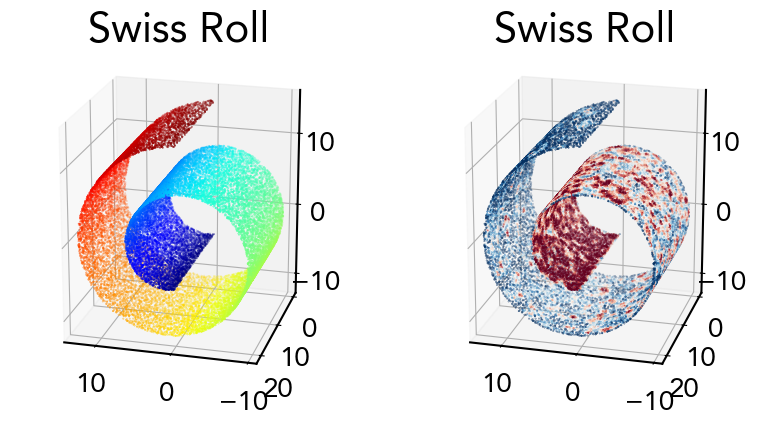

In [16]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c=t, cmap= 'jet')
ax.set_title("Swiss Roll")
ax.view_init(20, 105)
ax.set_aspect("equal")
ax1 = fig.add_subplot(1,2,2, projection='3d')
ax1.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c=nnd, vmin=vmin, vmax=vmax, cmap= 'RdBu')
ax1.set_title("Swiss Roll")
ax1.view_init(20, 105)
ax1.set_aspect("equal")
plt.show()

In [17]:
sorted_idx = np.argsort(t)
swiss_roll = swiss_roll[sorted_idx]
t = t[sorted_idx]

## 2D Plane

In [18]:
N_points = 10000
plane = rng.uniform(0, 1, (N_points,2))
print(plane.shape)
plane_embedded = np.zeros((N_points,3))
plane_embedded[:, :2] = plane

(10000, 2)


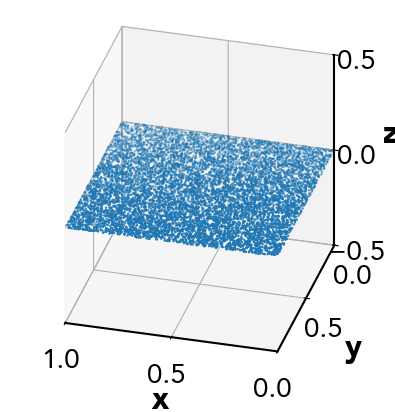

In [19]:
fig = plt.figure(figsize=(4.8,4.8))
ax = fig.add_subplot(projection='3d')
#ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c=t, cmap= 'jet')
ax.scatter(plane_embedded[:, 0], plane_embedded[:, 1], plane_embedded[:, 2], s=0.5)
ax.set_xlabel("x",fontweight="bold", labelpad=8)
ax.set_ylabel("y",fontweight="bold", labelpad=10)
ax.set_zlabel("z",fontweight="bold", labelpad=8)
#ax.set_title("Swiss Roll")
ax.set_proj_type('ortho')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set_zlim(-0.5, 0.5)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5])
ax.set_zticks([-0.5, 0, 0.5])
ax.view_init(30, 105)
ax.set_aspect("equal")
#plt.savefig(f"{modelddir}/plane_3d.pdf")
#plt.savefig(f"{modelddir}/plane_3d.png", dpi=300)
plt.show()

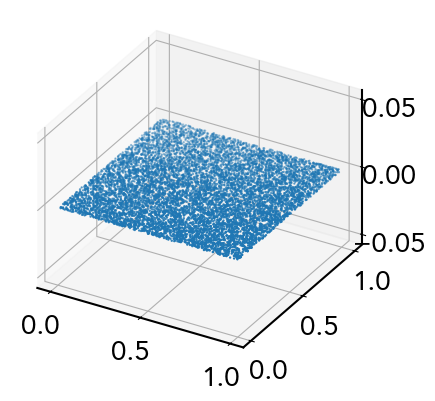

In [20]:
ax = plt.figure().add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.scatter(plane_embedded[:, 0], plane_embedded[:, 1], plane_embedded[:, 2], s=0.5)
#ax.scatter(plane_embedded[:, 0], plane_embedded[:, 1], s=3, color="red",marker="x")
#ax.set_aspect("equal")
plt.show()

## Computations for the paper

Clean and ordered section for the paper

In [21]:
figure_folder = "Figures/Model_datasets"

In [22]:
min_neighborhood_size = 40
max_neighborhood_size = 7500
n_neighborhoods = 12

### Plane

#### Preprocessing

In [23]:
neighborhoods_plane = np.logspace(np.log2(min_neighborhood_size), np.log2(max_neighborhood_size), n_neighborhoods,base=2,dtype=int)+1
print(neighborhoods_plane)


[  41   65  104  167  269  432  695 1119 1800 2896 4661 7500]


In [24]:
n_centers_neighborhoods_p, n_centers_min_p, n_centers_max_p = compute_n_centers_neighborhood(neighborhoods_plane,N_points, n_neighborhoods, coefficient=30)
n_total_centers_p = np.sum(n_centers_neighborhoods_p)
print(n_centers_neighborhoods_p)

[243 206 175 148 126 107  90  77  65  55  47  40]


In [25]:
centers_p = rng.choice(N_points, n_centers_max_p, replace=False)

#### FCI 

In [26]:
ID_FCI_plane, GoF = compute_id(plane_embedded, return_gof=True)
print(ID_FCI_plane, GoF)

1.9968358146253764 0.0019801619022427855


####  Local FCI

In [27]:
if compute:
    ids_plane, distances_plane, indexes_neighborhood_plane = local_fci_distance_ultrafast(plane_embedded, centers_p, n_centers_neighborhoods_p, neighborhoods_plane, fci_method="full", n_jobs=4) 

In [28]:
file_name_p = "lFCI_plane_smart.h5"

In [29]:
if save:
    with h5py.File(f"{base_folder}/{file_name_p}", "w") as f:
        f["local_ids"] = ids_plane
        f["selected_distances"] = distances_plane
        f["neighbor_indices"] = indexes_neighborhood_plane
        f["centers"] = centers_p
        f["n_centers_neigh"] = n_centers_neighborhoods_p
        f["neighborhoods"] = neighborhoods_plane

In [30]:
if  not compute:
    with h5py.File(f"{base_folder}/{file_name_p}", "r") as f:
        ids_plane = f["local_ids"][:]
        distances_plane = f["selected_distances"][:]
        indexes_neighborhood_plane = f["neighbor_indices"][:]
        centers_p =f["centers"][:]
        n_centers_neighborhoods_p = f["n_centers_neigh"][:]
        neighborhoods_plane = f["neighborhoods"][:]

#### Postprocessing 

In [31]:
local_ids_2d_p, GoF_p, k_p = unwrap_local_ids(ids_plane)

In [32]:
weights_p = compute_weights(n_centers_neighborhoods_p)

In [33]:
local_fci_p_flat = flatten_variable(local_ids_2d_p,n_centers_neighborhoods_p, n_total_centers_p)
gof_p_flat = flatten_variable(GoF_p,n_centers_neighborhoods_p, n_total_centers_p)
weights_p_flat = flatten_variable(weights_p,n_centers_neighborhoods_p, n_total_centers_p)
k_p_flat = flatten_variable(k_p,n_centers_neighborhoods_p, n_total_centers_p)

In [34]:
ID_local_plane1  = weighted_percentile(local_fci_p_flat, weights_p_flat, 0.5)

In [38]:
print(ID_local_plane1)

1.9918817099170791


In [36]:
kde = KernelDensity(bandwidth=0.3).fit(local_fci_p_flat[gof_p_flat<0.02].reshape(-1,1),
                                       sample_weight=weights_p_flat[gof_p_flat<0.02])
x_kde = np.linspace(0,10,300)
log_den = kde.score_samples(x_kde.reshape(-1,1))
            
peak = x_kde[np.argmax(log_den)]
ID_local_plane = peak

In [37]:
print(f"Local FCI ID: {ID_local_plane:.3f}\nFCI ID: {ID_FCI_plane:.3f}, GoF: {GoF:.3f}")

Local FCI ID: 1.973
FCI ID: 1.997, GoF: 0.002


#### Visualization

##### GoF *vs* ID

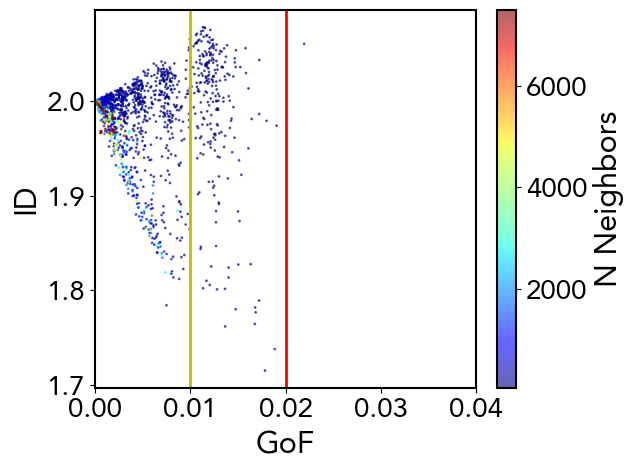

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
aa = ax.scatter(gof_p_flat, local_fci_p_flat, c=k_p_flat, s=1, cmap="jet", alpha = 0.6)
plt.colorbar(aa, ax=ax, fraction=0.05, label="N Neighbors")
ax.set_xlabel("GoF")
ax.set_ylabel("ID")
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
ax.set_xlim(0,0.04)
#ax.legend()
plt.show()

##### Local ID

Text(0, 0.5, 'ID')

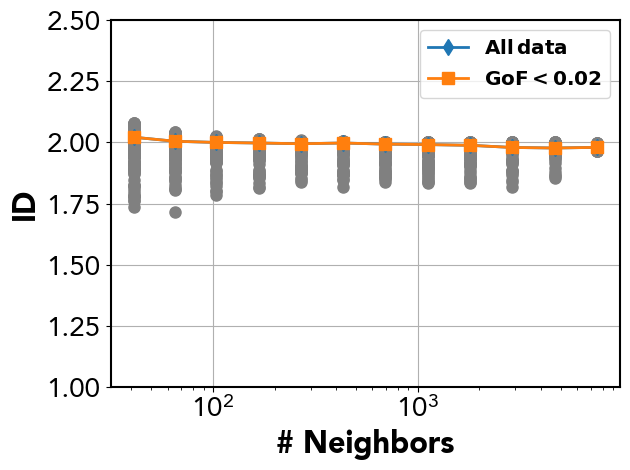

In [ ]:
local_median_id_p = np.zeros(n_neighborhoods)
local_median_id_p_g = np.zeros(n_neighborhoods)
fig, ax = plt.subplots(tight_layout=True)
for i, ncn in enumerate(n_centers_neighborhoods_p):
    local_median_id_p[i] = np.median(local_ids_2d_p[:ncn,i])
    local_median_id_p_g[i] = np.median(local_ids_2d_p[:ncn,i][GoF_p[:ncn,i]<0.02])
    ax.plot(k_p[:ncn,i],local_ids_2d_p[:ncn,i], "o", c="grey")
ax.plot(neighborhoods_plane,local_median_id_p, "d-", label=r"$\mathbf{All\, data}$")
ax.plot(neighborhoods_plane,local_median_id_p_g, "s-", label=r"$\mathbf{GoF<0.02}$")
ax.legend(fontsize="x-large")
ax.grid()
ax.set_ylim(1,2.5)
ax.set_xscale("log")
ax.set_xlabel("# Neighbors",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")

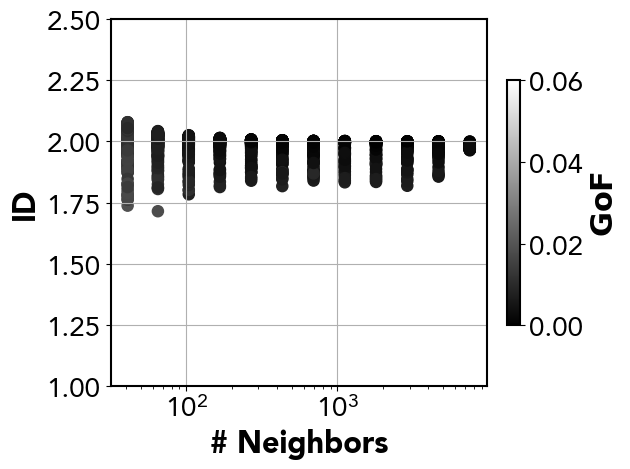

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
AA = ax.scatter(k_p_flat,local_fci_p_flat, c=gof_p_flat,vmin=0,vmax=0.06, cmap="gray")
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_ylim(1,2.5)
ax.set_xscale("log")
ax.set_xlabel("# Neighbors",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.savefig(f"{figure_folder}/plane_IDvsNeighborhood.pdf")
plt.show()

##### Values Distribution

In [ ]:
hist_g_plane, bin_edges_g_plane = np.histogram(local_fci_p_flat[gof_p_flat<0.02],range=(1.5,2.5), bins=20, weights=weights_p_flat[gof_p_flat<0.02])

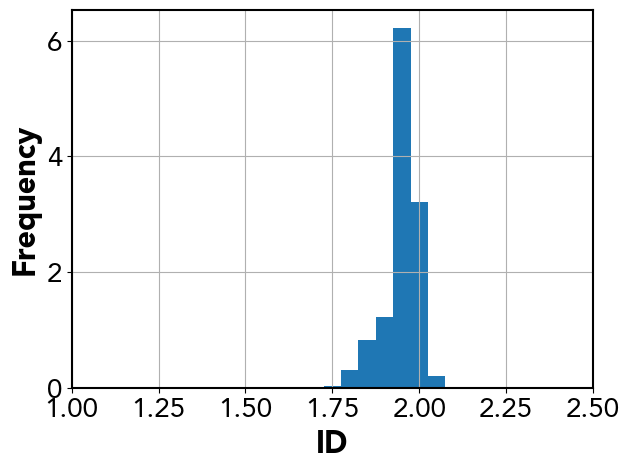

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_g_plane[:-1], hist_g_plane, width=np.diff(bin_edges_g_plane))
ax.set_xlabel("ID",fontweight="bold")
ax.set_ylabel("Frequency",fontweight="bold")
ax.grid()
ax.set_xlim(1,2.5)
plt.savefig(f"{figure_folder}/plane_hist.pdf")
plt.show()

#### New plots

In [ ]:
print(neighborhoods_plane)

[  41   65  104  167  269  432  695 1119 1800 2896 4661 7500]


In [ ]:
idx_c_plane = centers_p[0]
print(idx_c_plane) 

4391


In [ ]:
sel_neighb_p = neighborhoods_plane[9]
neighbors_P, indexes_P = KDTree_neighbors_dist(plane_embedded,n_neighbors=int(sel_neighb_p))
print(neighbors_P[idx_c_plane].shape)

(2895,)


In [ ]:
indexes_neigh_plane = indexes_P[idx_c_plane]

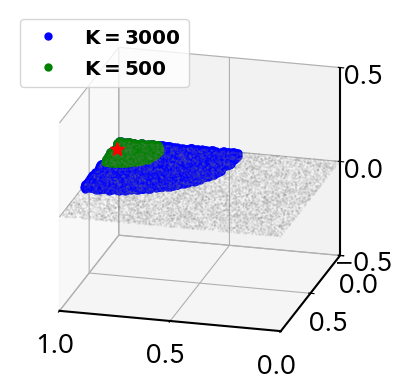

In [ ]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(plane_embedded[indexes_neigh_plane,0],plane_embedded[indexes_neigh_plane,1],plane_embedded[indexes_neigh_plane,2], "o", ms=5, c="b", label=r"$\mathbf{K=3000}$", zorder=1)
ax.plot(plane_embedded[indexes_neigh_plane[:500],0],plane_embedded[indexes_neigh_plane[:500],1],plane_embedded[indexes_neigh_plane[:500],2], "o", ms=5, c="g", label=r"$\mathbf{K=500}$" ,zorder=2)
ax.plot(plane_embedded[idx_c_plane,0],plane_embedded[idx_c_plane,1],plane_embedded[idx_c_plane,2], "*", ms=10, c="r",zorder=3)
ax.scatter(plane_embedded[:, 0], plane_embedded[:, 1], plane_embedded[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.legend(fontsize="x-large",loc='upper left')
ax.view_init(20, 105)
ax.set_zlim(-0.5, 0.5)
ax.set_aspect("equal")
ax.set_proj_type('ortho')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set_zlim(-0.5, 0.5)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5])
ax.set_zticks([-0.5, 0, 0.5])
plt.savefig(f"{figure_folder}/plane_neighborhoods.pdf")
plt.show()

### Swiss Roll

#### Preprocessing

In [39]:
n_neighborhoods_sr = 16
max_neighborhood_size_sr = 9000
neighborhoods_swiss = np.logspace(np.log2(min_neighborhood_size), np.log2(max_neighborhood_size_sr), n_neighborhoods_sr,base=2,dtype=int)+1
print(neighborhoods_swiss)


[  41   58   83  119  170  244  350  501  719 1032 1480 2124 3047 4372
 6273 9000]


In [40]:
n_centers_neighborhoods_sr, n_centers_min_sr, n_centers_max_sr = compute_n_centers_neighborhood(neighborhoods_swiss,n_samples, n_neighborhoods_sr, coefficient=8)
n_total_centers_sr = np.sum(n_centers_neighborhoods_sr)
print(n_centers_neighborhoods_sr)

[730 585 468 375 300 240 192 154 123  98  79  63  50  40  32  25]


In [41]:
centers_sr = rng.choice(n_samples, n_centers_max_sr, replace=False)

#### FCI 

In [42]:
ID_FCI_swiss, GoF_swiss = compute_id(swiss_roll[::2], return_gof = True)
print(ID_FCI_swiss, GoF_swiss)

2.9412083819381363 0.0027262444772051648


####  Local FCI

In [43]:
if compute:
    ids_swiss, distances_swiss, indexes_neighborhood_swiss = local_fci_distance_ultrafast(swiss_roll, centers_sr, n_centers_neighborhoods_sr, neighborhoods_swiss, fci_method="full", n_jobs=4) 

In [44]:
file_name_sr = "lFCI_swiss_roll_smart.h5"

In [45]:
if save:
    with h5py.File(f"{base_folder}/{file_name_sr}", "w") as f:
        f["local_ids"] = ids_swiss
        f["selected_distances"] = distances_swiss
        f["neighbor_indices"] = indexes_neighborhood_swiss
        f["centers"] = centers_sr
        f["n_centers_neigh"] = n_centers_neighborhoods_sr
        f["neighborhoods"] = neighborhoods_swiss

In [46]:
if  not compute:
    with h5py.File(f"{base_folder}/{file_name_sr}", "r") as f:
        ids_swiss = f["local_ids"][:]
        distances_swiss = f["selected_distances"][:]
        indexes_neighborhood_swiss = f["neighbor_indices"][:]
        centers_sr =f["centers"][:]
        n_centers_neighborhoods_sr = f["n_centers_neigh"][:]
        neighborhoods_swiss = f["neighborhoods"][:]

#### Postprocessing 

In [47]:
local_ids_2d_sr, GoF_sr, k_sr = unwrap_local_ids(ids_swiss)

In [48]:
weights_sr = compute_weights(n_centers_neighborhoods_sr)

In [49]:
local_fci_sr_flat = flatten_variable(local_ids_2d_sr,n_centers_neighborhoods_sr, n_total_centers_sr)
gof_sr_flat = flatten_variable(GoF_sr,n_centers_neighborhoods_sr, n_total_centers_sr)
weights_sr_flat = flatten_variable(weights_sr,n_centers_neighborhoods_sr, n_total_centers_sr)
k_sr_flat = flatten_variable(k_sr,n_centers_neighborhoods_sr, n_total_centers_sr)

In [50]:
ID_local_swiss  = weighted_percentile(local_fci_sr_flat, weights_sr_flat, 0.5)

In [51]:
kde = KernelDensity(bandwidth=0.3).fit(local_fci_sr_flat[gof_sr_flat<0.02].reshape(-1,1),
                                       sample_weight=weights_sr_flat[gof_sr_flat<0.02])
x_kde = np.linspace(0,10,300)
log_den = kde.score_samples(x_kde.reshape(-1,1))
            
peak = x_kde[np.argmax(log_den)]
ID_local_swiss = peak

In [52]:
print(f"Local FCI ID: {ID_local_swiss:.3f}\nFCI ID: {ID_FCI_swiss:.3f}, GoF: {GoF_swiss:.3f}")

Local FCI ID: 2.040
FCI ID: 2.941, GoF: 0.003


#### Visualization

##### GoF *vs* ID

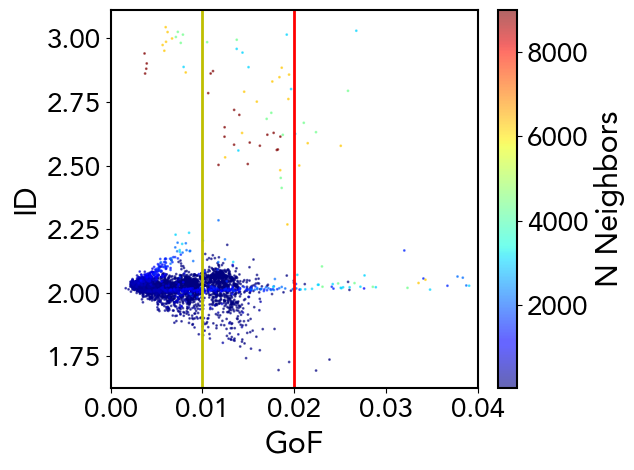

In [53]:
fig, ax = plt.subplots(tight_layout=True)
aa = ax.scatter(gof_sr_flat, local_fci_sr_flat, c=k_sr_flat, s=1, cmap="jet", alpha = 0.6)
plt.colorbar(aa, ax=ax, fraction=0.05, label="N Neighbors")
ax.set_xlabel("GoF")
ax.set_ylabel("ID")
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
ax.set_xlim(0,0.04)
#ax.legend()
plt.show()

##### Local ID

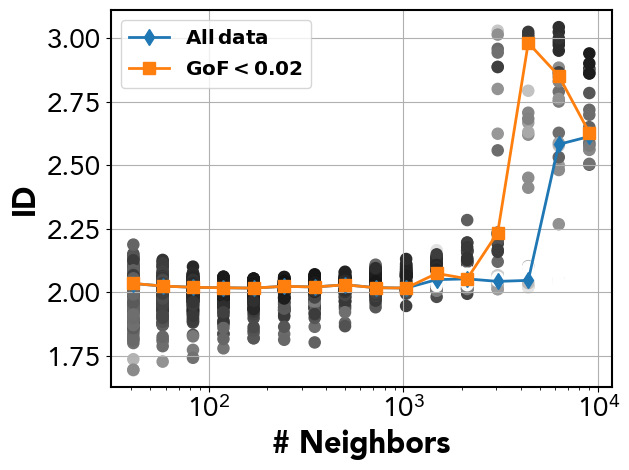

In [54]:
local_median_id_sr = np.zeros(n_neighborhoods_sr)
local_median_id_sr_g = np.zeros(n_neighborhoods_sr)
fig, ax = plt.subplots(tight_layout=True)
for i, ncn in enumerate(n_centers_neighborhoods_sr):
    local_median_id_sr[i] = np.median(local_ids_2d_sr[:ncn,i])
    local_median_id_sr_g[i] = np.median(local_ids_2d_sr[:ncn,i][GoF_sr[:ncn,i]<0.02])
    ax.scatter(k_sr[:ncn,i],local_ids_2d_sr[:ncn,i], c=1-GoF_sr[:ncn,i],vmin=0.96,vmax=1, cmap="Greys")
ax.plot(neighborhoods_swiss,local_median_id_sr, "d-", label=r"$\mathbf{All\,data}$")
ax.plot(neighborhoods_swiss,local_median_id_sr_g, "s-", label=r"$\mathbf{GoF<0.02}$")
ax.legend(fontsize="x-large")
ax.grid()
ax.set_xscale("log")
ax.set_xlabel("# Neighbors", fontweight="bold")
ax.set_ylabel("ID", fontweight="bold")
#plt.savefig(f"{figure_folder}/swissroll_IDvsNeighborhood.pdf")
plt.show()

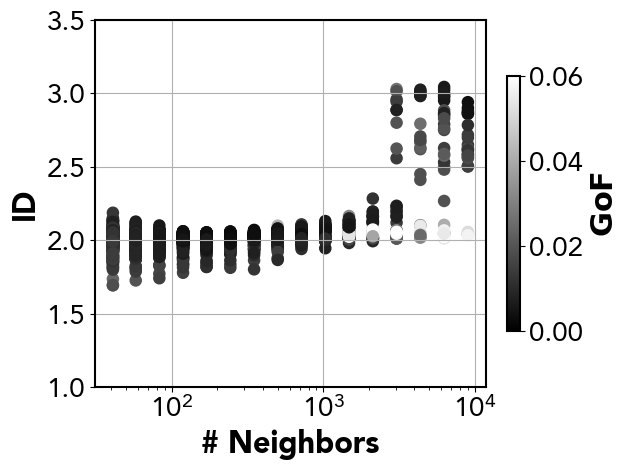

In [55]:
fig, ax = plt.subplots(tight_layout=True)
AA = ax.scatter(k_sr_flat,local_fci_sr_flat, c=gof_sr_flat,vmin=0,vmax=0.06, cmap="gray")
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_ylim(1,3.5)
ax.set_xscale("log")
ax.set_xlabel("# Neighbors",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.savefig(f"{figure_folder}/swissroll_IDvsNeighborhood.pdf")
plt.show()

##### Values Distribution

In [56]:
hist_g_swiss, bin_edges_g_swiss = np.histogram(local_fci_sr_flat[gof_sr_flat<0.02],range=(1.5,3.5), bins=20, weights=weights_sr_flat[gof_sr_flat<0.02])

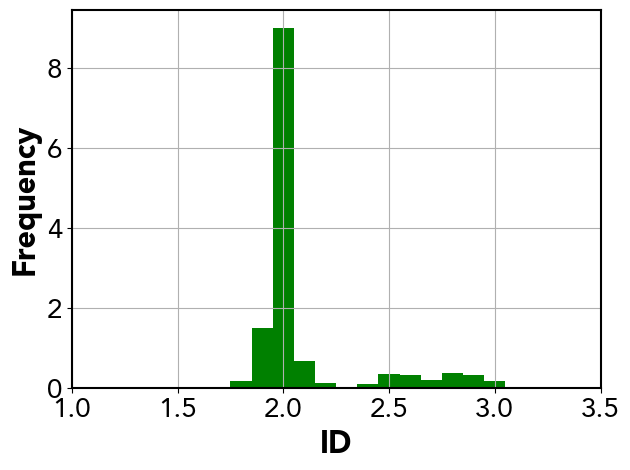

In [57]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_g_swiss[:-1], hist_g_swiss, width=np.diff(bin_edges_g_swiss), color="g")
ax.grid()
ax.set_xlim(1,3.5)
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
plt.savefig(f"{figure_folder}/swissroll_hist.pdf")
plt.show()

#### New plots

In [58]:
idx_worse = np.argmax(gof_sr_flat)
ID_worse = local_fci_sr_flat[idx_worse]
GoF_worse = gof_sr_flat[idx_worse]
k_worse = k_sr_flat[idx_worse]
print(f"ID: {ID_worse:.3f}, GoF: {GoF_worse:.3f}, k: {k_worse}")

ID: 2.047, GoF: 0.076, k: 3047.0


In [59]:
print(neighborhoods_swiss)

[  41   58   83  119  170  244  350  501  719 1032 1480 2124 3047 4372
 6273 9000]


In [60]:
n_centers_k = n_centers_neighborhoods_sr[12]
local_ids_k = ids_swiss[:n_centers_k,12,:]
print(n_centers_k)

50


In [61]:
A = np.argmax(local_ids_k[:,2])
print(A)
print(local_ids_k[A,2])
print(centers_sr[A])
idx_c_worse = centers_sr[A]

0
0.07613200367673317
21010


In [62]:
neighbors_A, indexes_A = KDTree_neighbors_dist(swiss_roll,n_neighbors=int(k_worse))
print(neighbors_A[idx_c_worse].shape)

(3046,)


In [63]:
print(neighbors_A[idx_c_worse].shape)
indexes_neigh_worse = indexes_A[idx_c_worse]

(3046,)


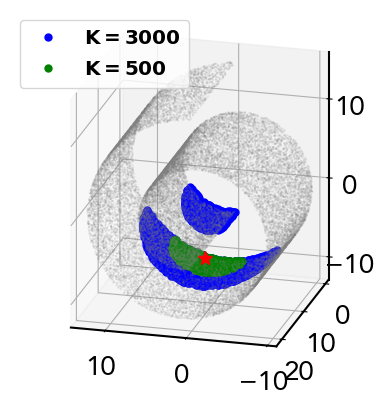

In [64]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(swiss_roll[indexes_neigh_worse,0],swiss_roll[indexes_neigh_worse,1],swiss_roll[indexes_neigh_worse,2], "o", ms=5, c="b", label=r"$\mathbf{K=3000}$", zorder=1)
ax.plot(swiss_roll[indexes_neigh_worse[:500],0],swiss_roll[indexes_neigh_worse[:500],1],swiss_roll[indexes_neigh_worse[:500],2], "o", ms=5, c="g",label=r"$\mathbf{K=500}$",zorder=2)
ax.plot(swiss_roll[idx_c_worse,0],swiss_roll[idx_c_worse,1],swiss_roll[idx_c_worse,2], "*", ms=10, c="r",zorder=3)
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.legend(loc="upper left", fontsize="x-large")
ax.view_init(20, 105)
ax.set_aspect("equal")
ax.set_proj_type('ortho')
plt.savefig(f"{figure_folder}/swiss_roll_neighborhoods.pdf")
plt.show()

In [65]:
neighborhood_good = np.array([idx_c_worse,*indexes_neigh_worse[:500]])
neighborhood_bad = np.array([idx_c_worse,*indexes_neigh_worse])
print(neighborhood_good.shape,neighborhood_bad.shape )

(501,) (3047,)


In [66]:
x_fci = np.linspace(0,2,2000)

In [67]:
norm_good = pyFCI.center_and_normalize(swiss_roll[neighborhood_good])
fci_good = pyFCI.FCI(norm_good)
id_good,_, gof_good = pyFCI.fit_FCI(fci_good)
y_fci_good = pyFCI.analytical_FCI(x_fci,id_good-1)
print(id_good, gof_good)

1.9866842588181415 0.00886982432029967


In [68]:
print(fci_good.shape)

(125250, 2)


In [69]:
norm_bad = pyFCI.center_and_normalize(swiss_roll[neighborhood_bad])
fci_bad = pyFCI.FCI(norm_bad)
id_bad,_, gof_bad = pyFCI.fit_FCI(fci_bad,3000)
y_fci_bad = pyFCI.analytical_FCI(x_fci,id_bad-1)
print(id_bad, gof_bad)

2.008409836292475 0.06079420303881949


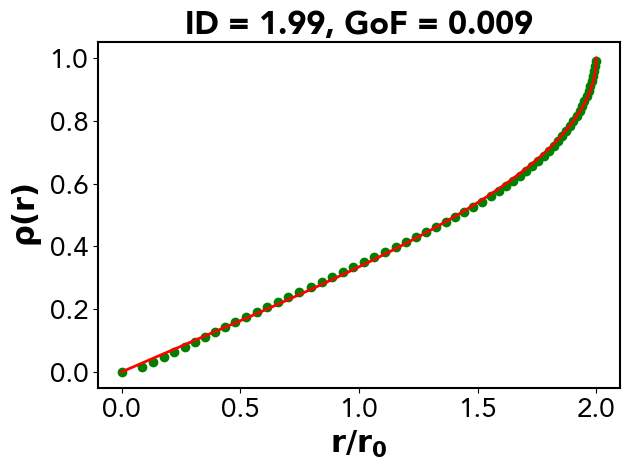

In [70]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(fci_good[::2000,0], fci_good[::2000,1],"o",ms=6,c="g")
ax.plot(x_fci,y_fci_good, lw=2,c="r")
ax.set_xlabel(r"$\mathbf{r/r_0}$")
ax.set_ylabel(r"$\mathbf{\rho(r)}$")
ax.set_title(f"ID = {id_good:.2f}, GoF = {gof_good:.3f}", fontweight="bold",fontsize="23")
plt.savefig(f"{figure_folder}/swiss_roll_good_fit.pdf")
plt.show()

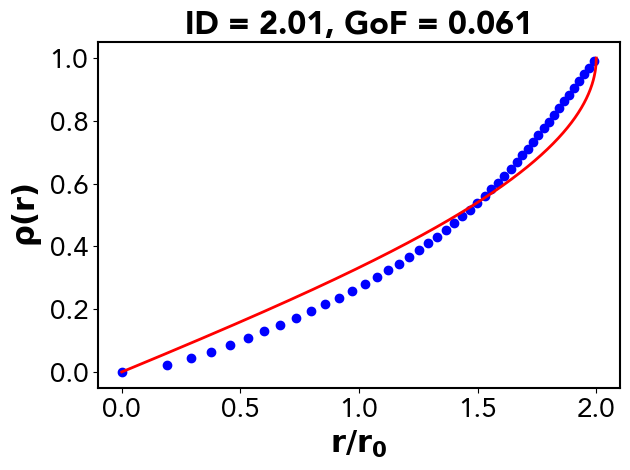

In [71]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(fci_bad[::100000,0], fci_bad[::100000,1],"o",ms=6,c="b")
ax.plot(x_fci,y_fci_bad,lw=2,c="r")
ax.set_xlabel(r"$\mathbf{r/r_0}$")
ax.set_ylabel(r"$\mathbf{\rho(r)}$")
ax.set_title(f"ID = {id_bad:.2f}, GoF = {gof_bad:.3f}", fontweight="bold",fontsize="23")
plt.savefig(f"{figure_folder}/swiss_roll_bad_fit.pdf")
plt.show()

##### Percentile GoF


In [72]:
selected_gofs = [0.00, 0.01, 0.02, 0.04, 0.06]
indexes_gofs = np.zeros(len(selected_gofs),dtype=int)
for i, sgof in enumerate(selected_gofs):
    indexes_gofs[i] = np.argmin(np.abs(gof_sr_flat - sgof))
    print(f"{sgof}: {indexes_gofs[i]},{gof_sr_flat[indexes_gofs[i]]}")

0.0: 2546,0.0016557576068104416
0.01: 893,0.009986942737225045
0.02: 3402,0.019985588919394504
0.04: 3515,0.04066198928809359
0.06: 3361,0.05989091177154897


In [73]:
print(ids_swiss.shape)

(731, 16, 3)


In [74]:
selected_centers = np.zeros_like(indexes_gofs)
selected_ks = np.zeros_like(indexes_gofs)
for i, sidx in enumerate(indexes_gofs):
    selk = int(k_sr_flat[sidx])
    sel_gof = gof_sr_flat[sidx]
    k_idx = np.argwhere(neighborhoods_swiss==selk).squeeze()
    n_centers_sel = int(n_centers_neighborhoods_sr[k_idx])
    local_ids_sel = ids_swiss[:n_centers_sel,k_idx,:].squeeze()
    idx_center_selected = np.argwhere(local_ids_sel[:,2]==sel_gof).squeeze()
    selected_ks[i] = selk
    selected_centers[i] = idx_center_selected

In [75]:
x_fci = np.linspace(0,2,2000)

1.851174280502352 0.008530519200670059
2.0275668593238803 0.008909929123601496
2.0244637951113873 0.04628968469895057
2.101466296655876 0.04386034237081815
2.004112354638022 0.008473308765058253


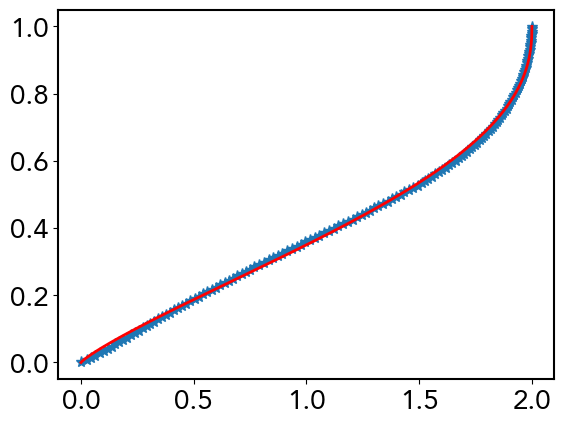

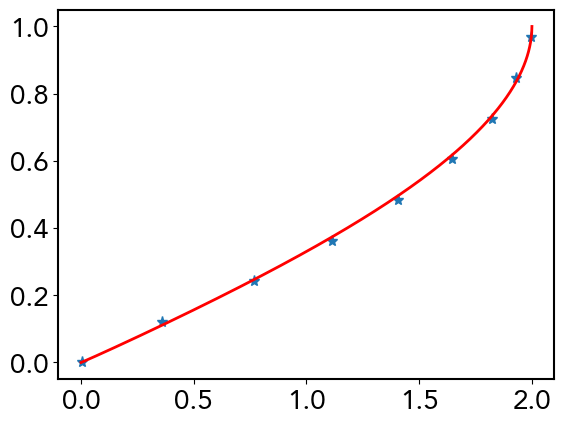

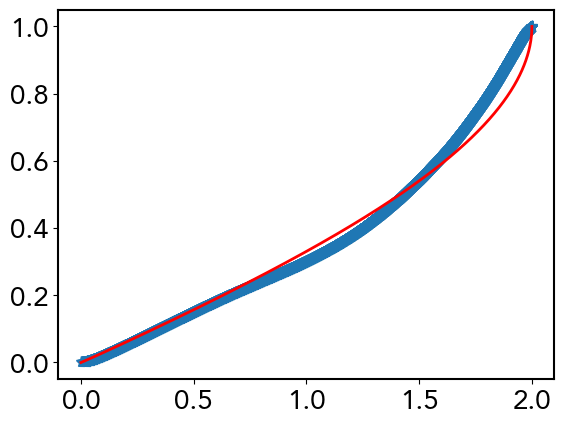

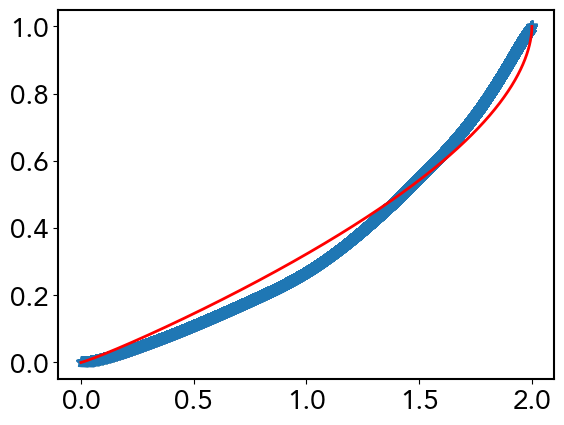

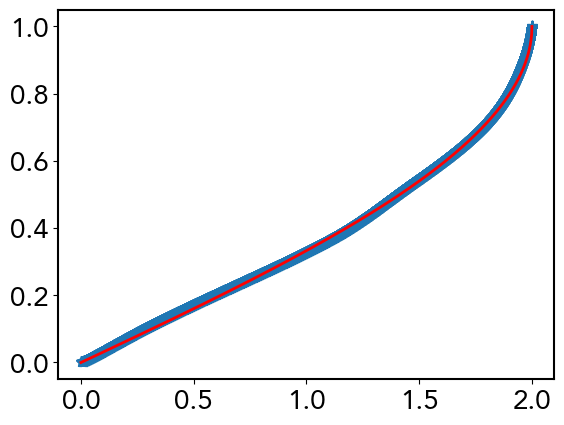

In [76]:
#for i, ks, s_cent in enumerate(zip(selected_ks,selected_centers )):
for i in range(len(selected_gofs)):
    ks = selected_ks[i]
    s_cent = selected_centers[i]
    neighbors_A, indexes_A = KDTree_neighbors_dist(swiss_roll,n_neighbors=int(ks))
    indexes_neigh_s_cent = indexes_A[s_cent]
    neighborhood_s_cent = np.array([s_cent,*indexes_neigh_s_cent])
    norm_s_cent = pyFCI.center_and_normalize(swiss_roll[neighborhood_s_cent])
    fci_s_cent = pyFCI.FCI(norm_s_cent)
    id_s_cent, _, gof_s_cent =  pyFCI.fit_FCI(fci_s_cent)
    y_fci_scent = pyFCI.analytical_FCI(x_fci,id_s_cent-1)
    print(id_s_cent, gof_s_cent)
    fig, ax = plt.subplots()
    ax.plot(fci_s_cent[::200,0], fci_s_cent[::200,1],"*")
    ax.plot(x_fci,y_fci_scent, lw=2,c="r")

plt.show()



In [77]:
new_centers = rng.choice(N_points,10, replace=False)
new_k = 1500

2.0147244236378663 0.01508487748379244
2.0183694625416315 0.016929533459615204
1.9268882407155314 0.009781467123022646
2.008659565737748 0.014147837892106692
2.0195933477899914 0.020148675259598365
2.017756043463688 0.015106399622231051
1.977576327363182 0.010028179976360973
2.015783723939551 0.01438943124186754
2.1489962294882483 0.009674267424435239
2.1251270128027624 0.006251610636482416


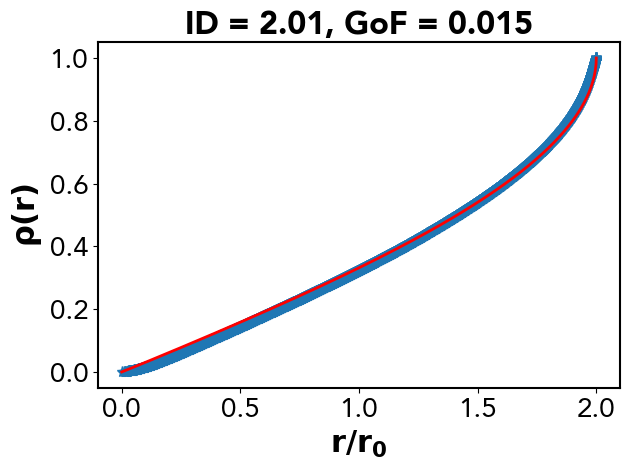

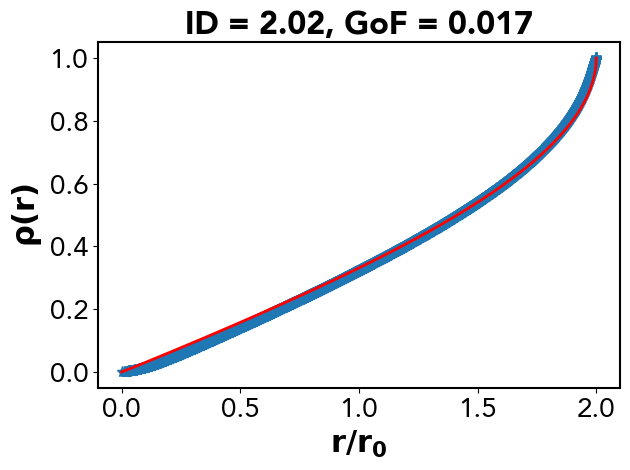

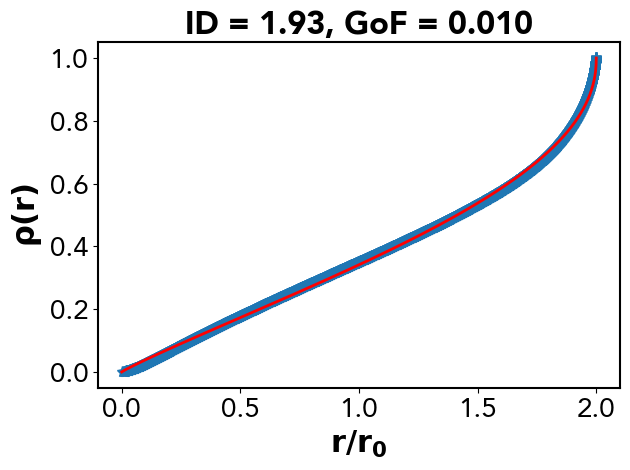

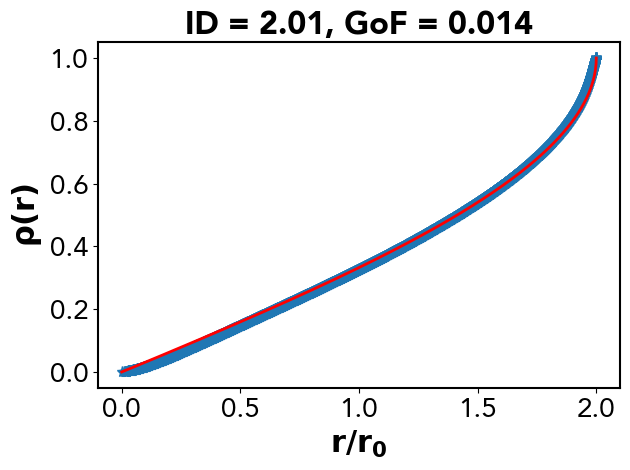

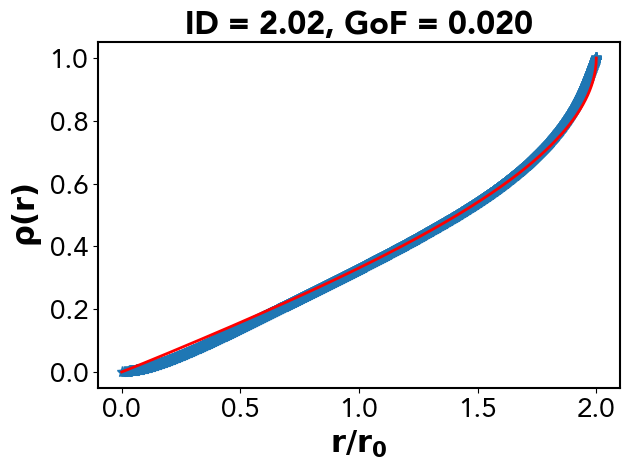

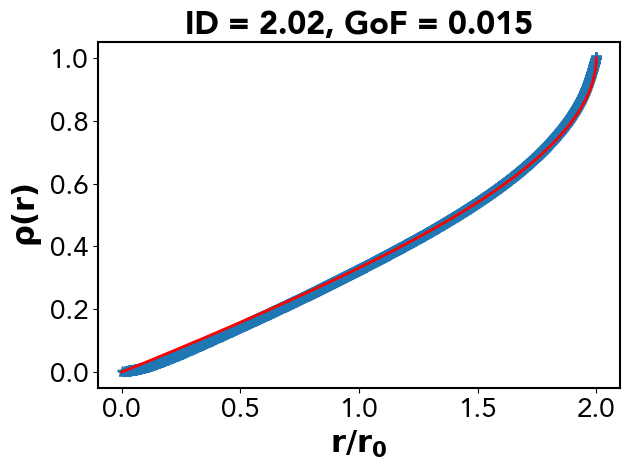

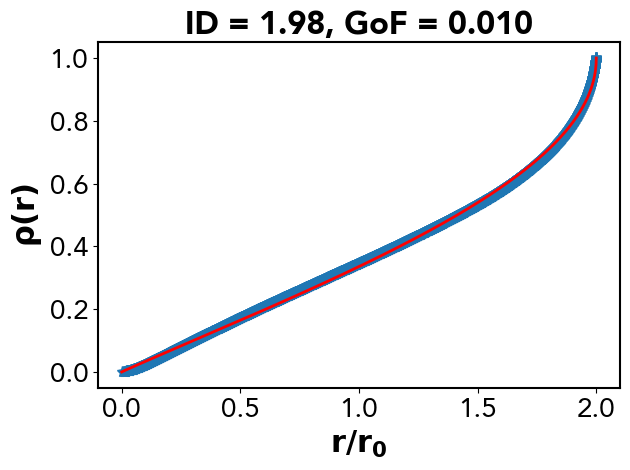

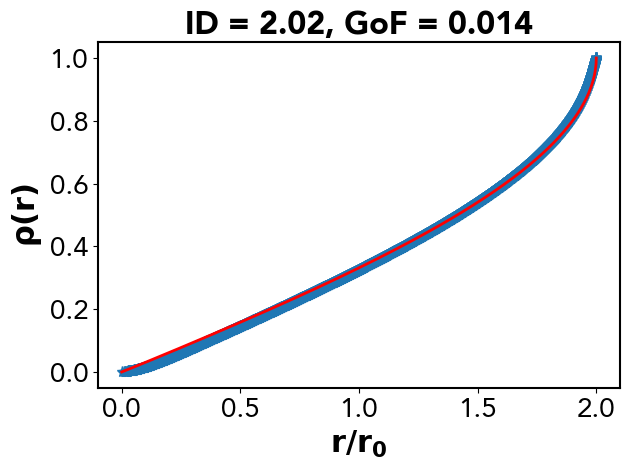

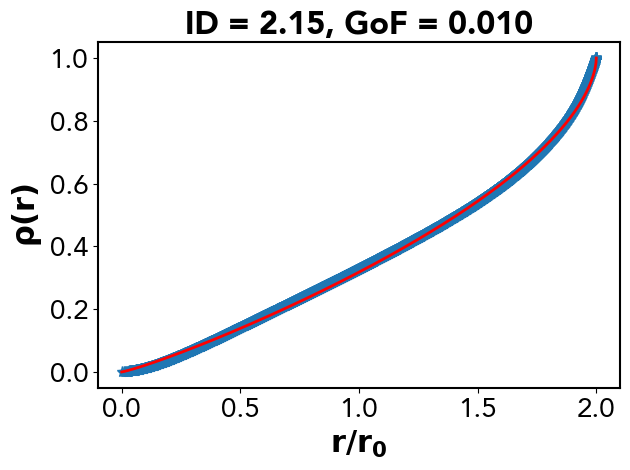

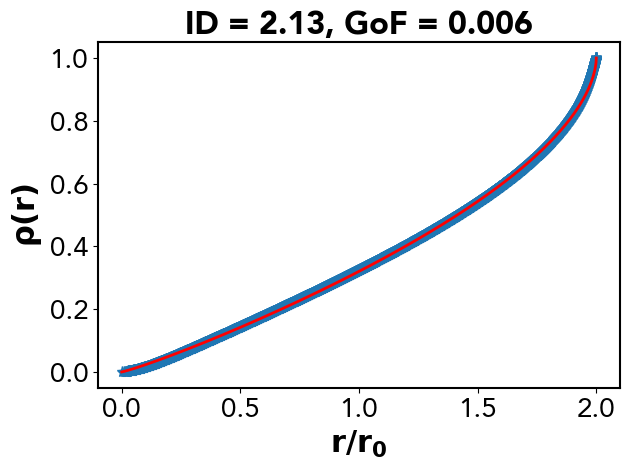

In [78]:
neighbors_A, indexes_A = KDTree_neighbors_dist(swiss_roll,n_neighbors=int(new_k))
for i, s_cent in enumerate(new_centers):
    indexes_neigh_s_cent = indexes_A[s_cent]
    neighborhood_s_cent = np.array([s_cent,*indexes_neigh_s_cent])
    norm_s_cent = pyFCI.center_and_normalize(swiss_roll[neighborhood_s_cent])
    fci_s_cent = pyFCI.FCI(norm_s_cent)
    id_s_cent, _, gof_s_cent =  pyFCI.fit_FCI(fci_s_cent)
    y_fci_scent = pyFCI.analytical_FCI(x_fci,id_s_cent-1)
    print(id_s_cent, gof_s_cent)
    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(fci_s_cent[::200,0], fci_s_cent[::200,1],"*")
    ax.plot(x_fci,y_fci_scent, lw=2,c="r")
    ax.set_xlabel(r"$\mathbf{r/r_0}$")
    ax.set_ylabel(r"$\mathbf{\rho(r)}$")
    ax.set_title(f"ID = {id_s_cent:.2f}, GoF = {gof_s_cent:.3f}", fontweight="bold",fontsize="23")
    plt.savefig(f"{figure_folder}/swissroll_k{new_k}_gof{gof_s_cent:.3f}_fit.pdf")
plt.show()

2.0747682703527506 0.057775410023997886
2.0205444158291685 0.03267315093162525
2.0301329049446237 0.04675600672019943
2.045358829127424 0.044570323393880035
2.123376341948261 0.06110984489408268
2.033042636524753 0.042579328294628634
2.0325233388553747 0.0514738682390029
2.0345839048887795 0.05547624602661038
2.1093030733439195 0.05876848689378599
2.03661226311414 0.04224855683469196


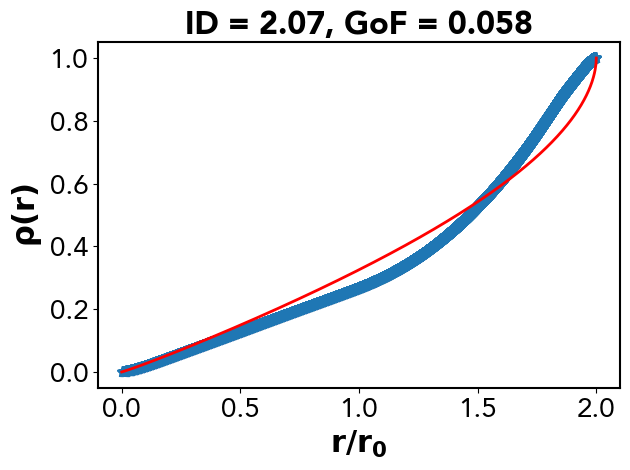

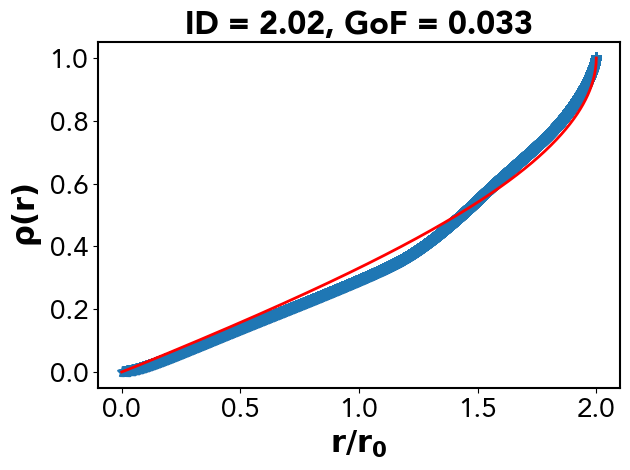

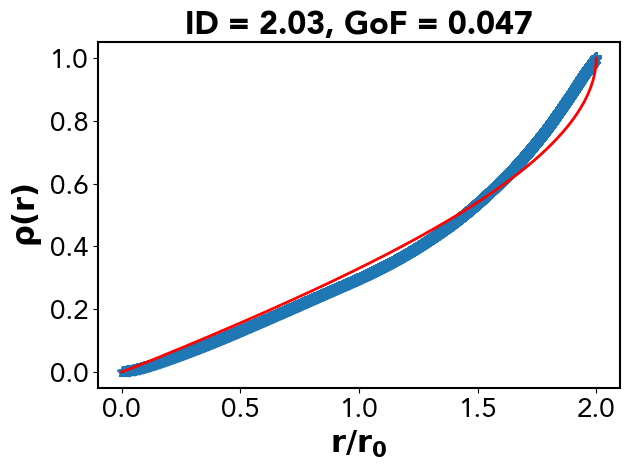

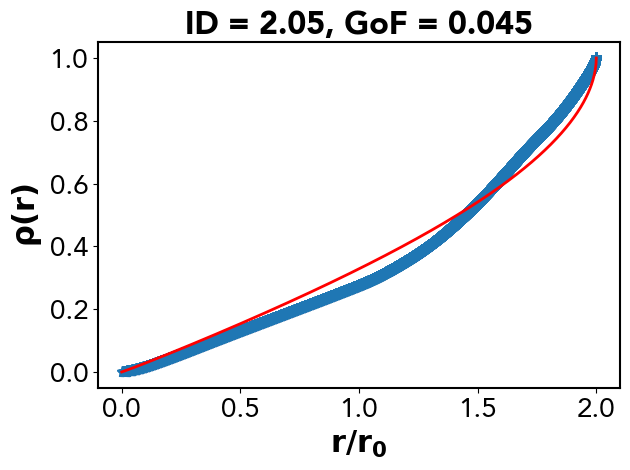

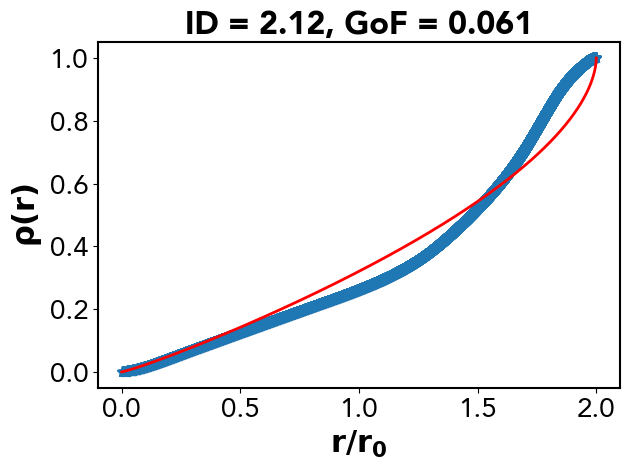

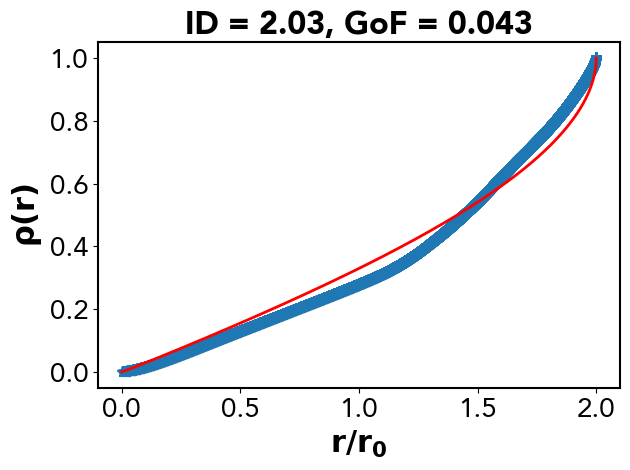

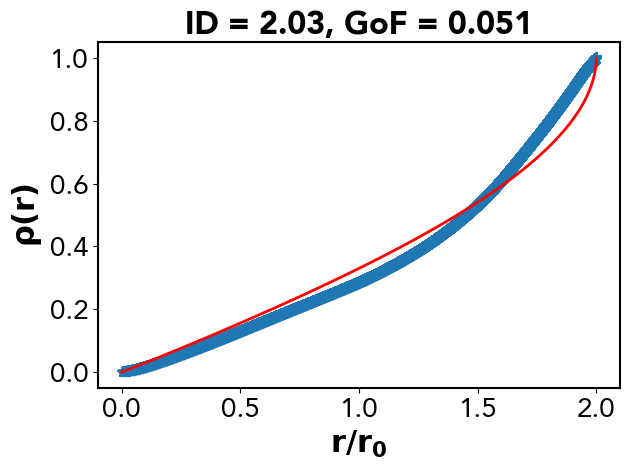

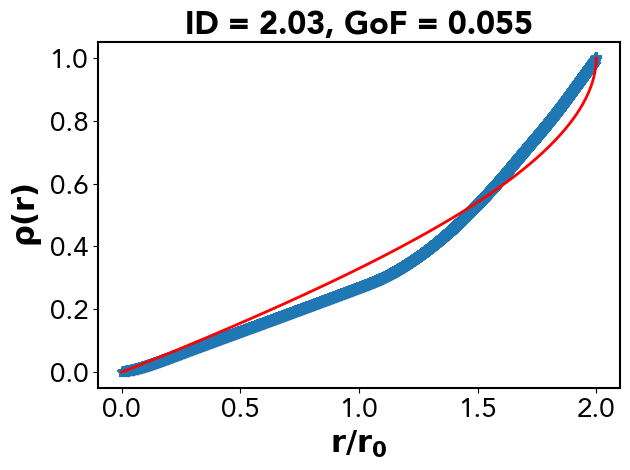

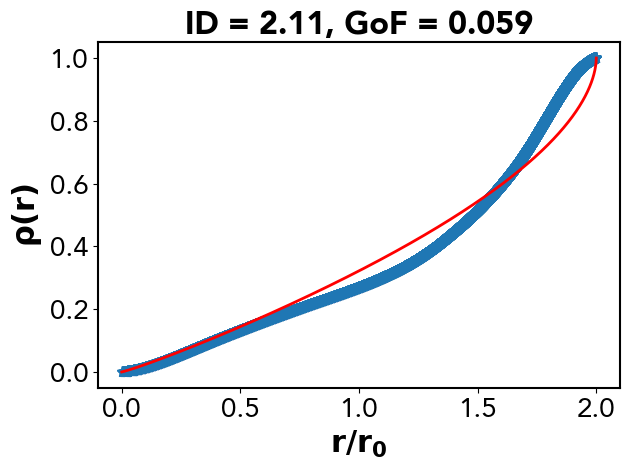

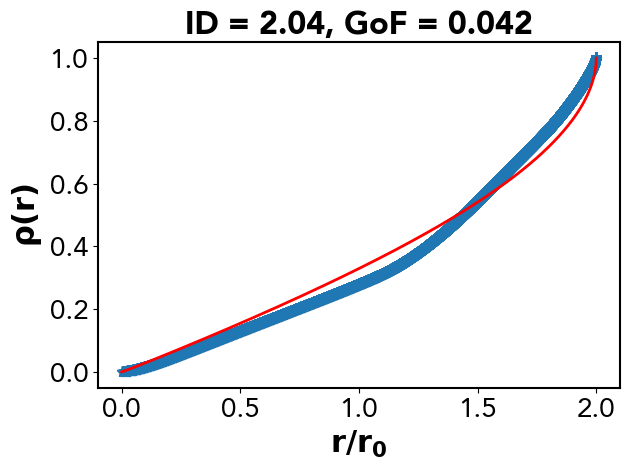

In [79]:
new_k1 = 3500
neighbors_A, indexes_A = KDTree_neighbors_dist(swiss_roll,n_neighbors=int(new_k1))
for i, s_cent in enumerate(new_centers):
    indexes_neigh_s_cent = indexes_A[s_cent]
    neighborhood_s_cent = np.array([s_cent,*indexes_neigh_s_cent])
    norm_s_cent = pyFCI.center_and_normalize(swiss_roll[neighborhood_s_cent])
    fci_s_cent = pyFCI.FCI(norm_s_cent)
    id_s_cent, _, gof_s_cent =  pyFCI.fit_FCI(fci_s_cent)
    y_fci_scent = pyFCI.analytical_FCI(x_fci,id_s_cent-1)
    print(id_s_cent, gof_s_cent)
    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(fci_s_cent[::200,0], fci_s_cent[::200,1],"*")
    ax.plot(x_fci,y_fci_scent, lw=2,c="r")
    ax.set_xlabel(r"$\mathbf{r/r_0}$")
    ax.set_ylabel(r"$\mathbf{\rho(r)}$")
    ax.set_title(f"ID = {id_s_cent:.2f}, GoF = {gof_s_cent:.3f}", fontweight="bold",fontsize="23")
    plt.savefig(f"{figure_folder}/swissroll_k{new_k1}_gof{gof_s_cent:.3f}_fit.pdf")
plt.show()